# matplotlib ------ 案例分析
## 案例：华盛顿自行车租赁情况分析
### 步骤1：确认数据

In [2]:
import pandas as pd # 读取数据到DataFrame
import urllib.request # 获取网络数据
import tempfile # 创建临时文件系统
import shutil # 文件操作
import zipfile # 压缩解压

temp_dir = tempfile.mkdtemp() # 建立临时目录,可以猜猜看这个路径是什么呢？
data_source = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip' # 网络数据地址
zipname = temp_dir + '/Bike-Sharing-Dataset.zip' # 拼接文件和路径
urllib.request.urlretrieve(data_source, zipname) # 获得数据

zip_ref = zipfile.ZipFile(zipname, 'r') # 创建一个ZipFile对象处理压缩文件
zip_ref.extractall(temp_dir) # 解压
zip_ref.close()

daily_path = temp_dir + '/day.csv'
daily_data = pd.read_csv(daily_path) # 读取csv文件，在读取值之前先用excel把从网上下载下来的数据看一下
daily_data['dteday'] = pd.to_datetime(daily_data['dteday']) # 把字符串数据传换成日期数据
drop_list = ['instant', 'season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'atemp', 'hum'] # 不关注的列
daily_data.drop(drop_list, inplace = True, axis = 1) # inplace=true在对象上直接操作

shutil.rmtree(temp_dir) # 删除临时文件目录

daily_data.head() # 看一看数据哈~

,dteday,weekday,temp,windspeed,casual,registered,cnt
0,2011-01-01,6,0.344167,0.160446,331,654,985
1,2011-01-02,0,0.363478,0.248539,131,670,801
2,2011-01-03,1,0.196364,0.248309,120,1229,1349
3,2011-01-04,2,0.200000,0.160296,108,1454,1562
4,2011-01-05,3,0.226957,0.186900,82,1518,1600


### 步骤2：配置参数

In [3]:
from __future__ import division, print_function # 引入3.x版本的除法和打印
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
# 在notebook中显示绘图结果
%matplotlib inline

# 设置一些全局的资源参数，可以进行个性化修改
import matplotlib
# 设置图片尺寸 14" x 7"
# rc: resource configuration
matplotlib.rc('figure', figsize = (14, 7))
# 设置字体 14
matplotlib.rc('font', size = 14)
# 不显示网格
matplotlib.rc('axes', grid = False)
# 设置背景颜色是白色
matplotlib.rc('axes', facecolor = 'white')

### 步骤3：关联分析
#### 散点图
* 分析变量关系

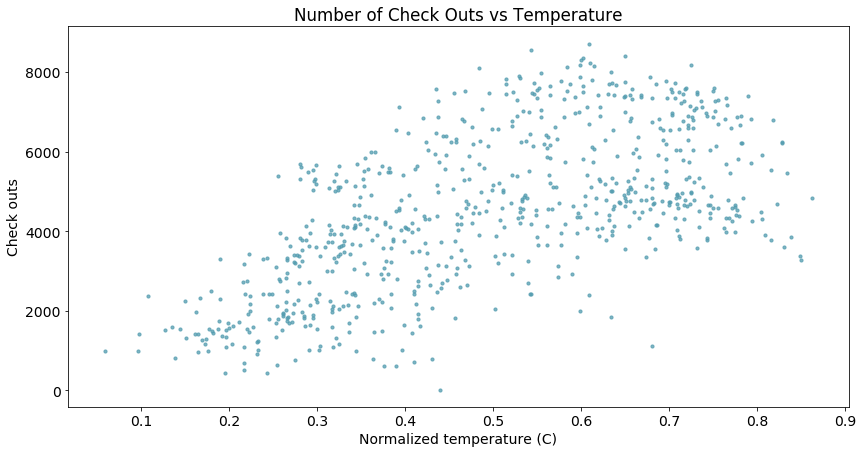

In [4]:
# 包装一个散点图的函数便于复用
def scatterplot(x_data, y_data, x_label, y_label, title):

    # 创建一个绘图对象
    fig, ax = plt.subplots()
    # 不显示顶部和右侧的坐标线
    # ax.spines['top'].set_color('none')
    # ax.spines['right'].set_color('none')
    # 设置数据、点的大小、点的颜色和透明度
    ax.scatter(x_data, y_data, s = 10, color = '#539caf', alpha = 0.75)

    # 添加标题和坐标说明
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# 绘制散点图
scatterplot(x_data = daily_data['temp']
            , y_data = daily_data['cnt']
            , x_label = 'Normalized temperature (C)'
            , y_label = 'Check outs'
            , title = 'Number of Check Outs vs Temperature')

#### 曲线图
* 拟合变量关系

C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


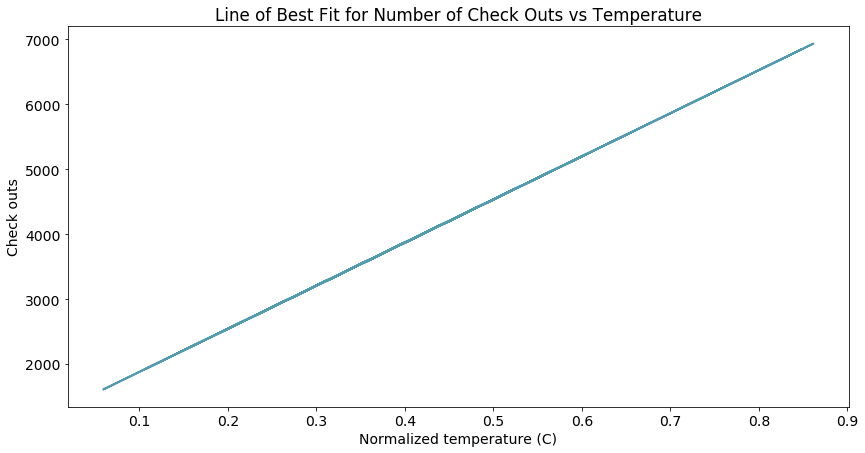

In [5]:
# 线性回归
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
x = sm.add_constant(daily_data['temp']) # 线性回归增加常数项
y = daily_data['cnt']
regr = sm.OLS(y, x) # 普通最小二乘模型，ordinary least square model
res = regr.fit()
# 从模型获得拟合数据
st, data, ss2 = summary_table(res, alpha=0.05) # 置信水平alpha=5%，st数据汇总，data数据详情，ss2数据列名
fitted_values = data[:,2]

# 包装曲线绘制函数
def lineplot(x_data, y_data, x_label, y_label, title):
    # 创建绘图对象
    _, ax = plt.subplots()

    # 绘制拟合曲线，lw=linewidth，alpha=transparancy
    ax.plot(x_data, y_data, lw = 2, color = '#539caf', alpha = 1)

    # 添加标题和坐标说明
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# 调用绘图函数
lineplot(x_data = daily_data['temp']
         , y_data = fitted_values
         , x_label = 'Normalized temperature (C)'
         , y_label = 'Check outs'
         , title = 'Line of Best Fit for Number of Check Outs vs Temperature')

In [6]:
x.head()
type(regr)
st

Obs,Dep Var,Predicted,Std Error,Mean ci,Mean ci,Predict ci,Predict ci,Residual,Std Error,Student,Cook's
,Population,Value,Mean Predict,95% low,95% upp,95% low,95% upp,,Residual,Residual,D
1.0,985.0,3500.1553571,72.4322812131,3357.95460434,3642.35610986,533.478561836,6466.83215236,-2515.1553571,1507.64951896,-1.66826263364,0.00321190276131
2.0,801.0,3628.39410788,68.8273305923,3493.2706787,3763.51753706,662.048124254,6594.74009151,-2827.39410788,1507.81839289,-1.8751556031,0.00366326559508
3.0,1349.0,2518.63849718,106.979293111,2308.61424066,2728.66275371,-452.061814493,5489.33880886,-1169.63849718,1505.59255385,-0.776862567625,0.00152350164479
4.0,1562.0,2542.78411874,106.034287359,2334.61511966,2750.95311782,-427.785605346,5513.35384282,-980.784118739,1505.65940281,-0.651398395219,0.00105221026773
5.0,1600.0,2721.79773817,99.1345934737,2527.1743799,2916.42109644,-247.853487994,5691.44896433,-1121.79773817,1506.12942331,-0.744821607499,0.00120171204152
6.0,1606.0,2571.65792581,104.908465017,2365.69916755,2777.61668407,-398.757729205,5542.07358083,-965.657925813,1505.73826455,-0.641318580091,0.000998250968489
7.0,1510.0,2519.68772936,106.938162754,2309.74422092,2729.63123781,-451.006874632,5490.38233336,-1009.68772936,1505.59547579,-0.670623514483,0.00113442658021
8.0,959.0,2310.35926879,115.252811327,2084.09224731,2536.62629027,-661.533548672,5282.25208625,-1351.35926879,1504.98182609,-0.897923978459,0.00236422980202
9.0,822.0,2133.27145526,122.436253333,1892.90173201,2373.64117851,-839.728335748,5106.27124627,-1311.27145526,1504.41446126,-0.871615827304,0.00251596898807


#### 带置信区间的曲线图
* 评估曲线拟合结果

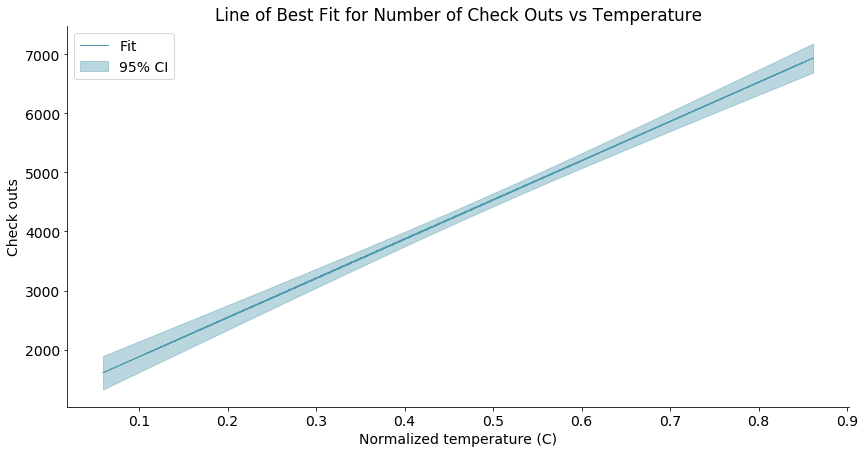

In [6]:
# 获得5%置信区间的上下界
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

# 创建置信区间DataFrame，上下界
CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
CI_df['x_data'] = daily_data['temp']
CI_df['low_CI'] = predict_mean_ci_low
CI_df['upper_CI'] = predict_mean_ci_upp
CI_df.sort_values('x_data', inplace = True) # 根据x_data进行排序

# 绘制置信区间
def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
    # 创建绘图对象
    _, ax = plt.subplots()

    # 绘制预测曲线
    ax.plot(x_data, y_data, lw = 1, color = '#539caf', alpha = 1, label = 'Fit')
    # 绘制置信区间，顺序填充
    ax.fill_between(sorted_x, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = '95% CI')
    # 添加标题和坐标说明
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # 显示图例，配合label参数，loc=“best”自适应方式
    ax.legend(loc = 'best')

# Call the function to create plot
lineplotCI(x_data = daily_data['temp']
           , y_data = fitted_values
           , sorted_x = CI_df['x_data']
           , low_CI = CI_df['low_CI']
           , upper_CI = CI_df['upper_CI']
           , x_label = 'Normalized temperature (C)'
           , y_label = 'Check outs'
           , title = 'Line of Best Fit for Number of Check Outs vs Temperature')

#### 双坐标曲线图
* 曲线拟合不满足置信阈值时，考虑增加独立变量
* 分析不同尺度多变量的关系

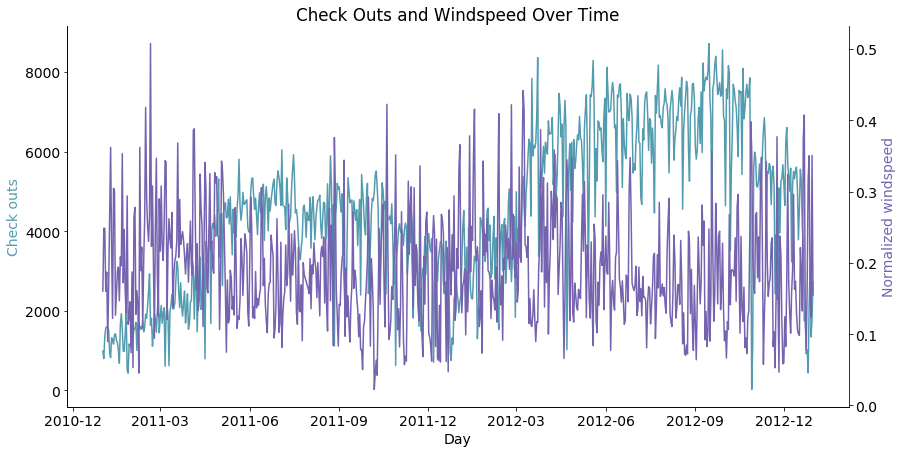

In [7]:
# 双纵坐标绘图函数
def lineplot2y(x_data, x_label, y1_data, y1_color, y1_label, y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    ax1.plot(x_data, y1_data, color = y1_color)
    # 添加标题和坐标说明
    ax1.set_ylabel(y1_label, color = y1_color)
    ax1.set_xlabel(x_label)
    ax1.set_title(title)

    ax2 = ax1.twinx() # 两个绘图对象共享横坐标轴
    ax2.plot(x_data, y2_data, color = y2_color)
    ax2.set_ylabel(y2_label, color = y2_color)
    # 右侧坐标轴可见
    ax2.spines['right'].set_visible(True)

# 调用绘图函数
lineplot2y(x_data = daily_data['dteday']
           , x_label = 'Day'
           , y1_data = daily_data['cnt']
           , y1_color = '#539caf'
           , y1_label = 'Check outs'
           , y2_data = daily_data['windspeed']
           , y2_color = '#7663b0'
           , y2_label = 'Normalized windspeed'
           , title = 'Check Outs and Windspeed Over Time')

### 步骤4：分布分析
#### 灰度图
* 粗略区间计数

array([   20. ,   712.6,  1405.2,  2097.8,  2790.4,  3483. ,  4175.6,
        4868.2,  5560.8,  6253.4,  6946. ])

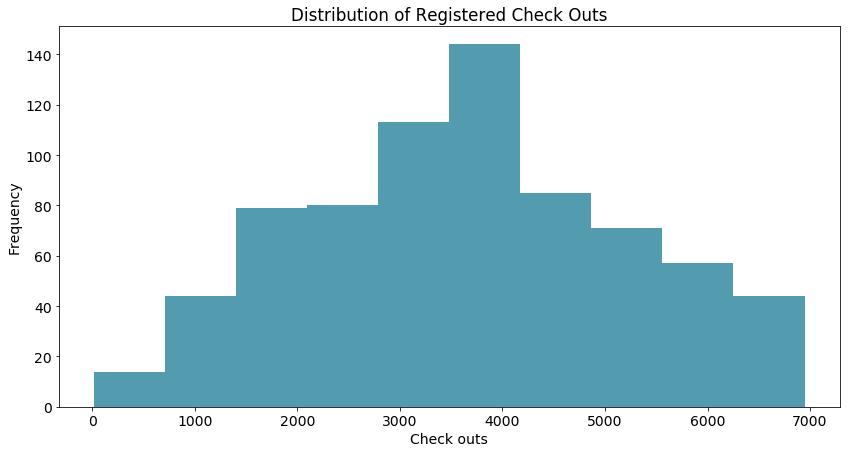

In [8]:
# 绘制灰度图的函数
def histogram(data, x_label, y_label, title):
    _, ax = plt.subplots()
    res = ax.hist(data, color = '#539caf', bins=10) # 设置bin的数量
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    return res

# 绘图函数调用
res = histogram(data = daily_data['registered']
           , x_label = 'Check outs'
           , y_label = 'Frequency'
           , title = 'Distribution of Registered Check Outs')
res[0] # value of bins
res[1] # boundary of bins

#### 堆叠直方图
* 比较两个分布

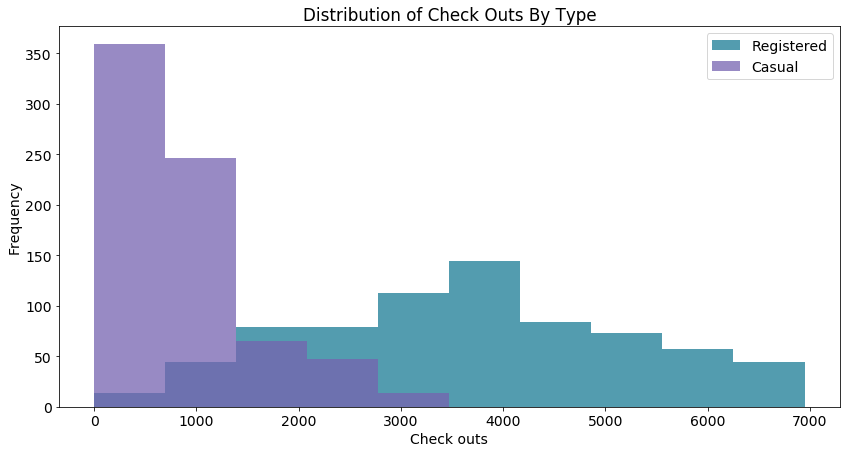

In [9]:
# 绘制堆叠的直方图
def overlaid_histogram(data1, data1_name, data1_color, data2, data2_name, data2_color, x_label, y_label, title):
    # 归一化数据区间，对齐两个直方图的bins
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins
    bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth) # 生成直方图bins区间

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

# Call the function to create plot
overlaid_histogram(data1 = daily_data['registered']
                   , data1_name = 'Registered'
                   , data1_color = '#539caf'
                   , data2 = daily_data['casual']
                   , data2_name = 'Casual'
                   , data2_color = '#7663b0'
                   , x_label = 'Check outs'
                   , y_label = 'Frequency'
                   , title = 'Distribution of Check Outs By Type')

* registered：注册的分布，正态分布，why
* casual：偶然的分布，疑似指数分布，why

不过总感觉灰度图太糙了，有没有~肿么破~

#### 密度图
* 精细刻画概率分布

KDE: kernal density estimate

$
\hat{f}_h(x) = \frac{1}{n}\sum\limits_{i=1}^n K_h(x-x_i) = \frac{1}{nh}\sum\limits_{i=1}^n K(\frac{x-x_i}{h})
$

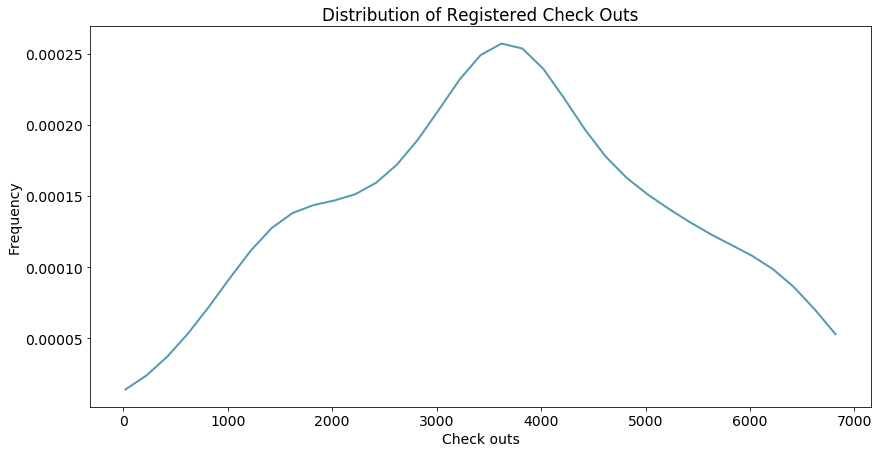

In [10]:
# 计算概率密度
from scipy.stats import gaussian_kde
data = daily_data['registered']
density_est = gaussian_kde(data) # kernal density estimate: https://en.wikipedia.org/wiki/Kernel_density_estimation
# 控制平滑程度，数值越大，越平滑哈
density_est.covariance_factor = lambda : .3
density_est._compute_covariance()
x_data = np.arange(min(data), max(data), 200)

# 绘制密度估计曲线
def densityplot(x_data, density_est, x_label, y_label, title):
    _, ax = plt.subplots()
    ax.plot(x_data, density_est(x_data), color = '#539caf', lw = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

# 调用绘图函数
densityplot(x_data = x_data
            , density_est = density_est
            , x_label = 'Check outs'
            , y_label = 'Frequency'
            , title = 'Distribution of Registered Check Outs')

In [11]:
type(density_est)

scipy.stats.kde.gaussian_kde

### 步骤5：组间分析
* 组间定量比较
* 分组粒度
* 组间聚类

#### 柱状图
* 一级类间均值方差比较

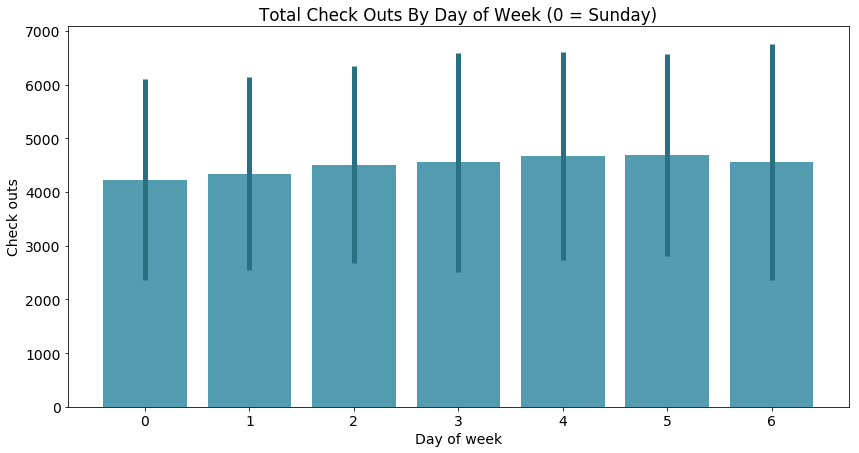

In [12]:
# 分天分析统计特征
mean_total_co_day = daily_data[['weekday', 'cnt']].groupby('weekday').agg([np.mean, np.std])
mean_total_co_day.columns = mean_total_co_day.columns.droplevel()

# 定义绘制柱状图的函数
def barplot(x_data, y_data, error_data, x_label, y_label, title):
    _, ax = plt.subplots()
    # 柱状图
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # 绘制方差
    # ls='none'去掉bar之间的连线
    ax.errorbar(x_data, y_data, yerr = error_data, color = '#297083', ls = 'none', lw = 5)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

# 绘图函数调用
barplot(x_data = mean_total_co_day.index.values
        , y_data = mean_total_co_day['mean']
        , error_data = mean_total_co_day['std']
        , x_label = 'Day of week'
        , y_label = 'Check outs'
        , title = 'Total Check Outs By Day of Week (0 = Sunday)')

In [13]:
mean_total_co_day.columns
daily_data[['weekday', 'cnt']].groupby('weekday').agg([np.mean, np.std])

cnt             
                mean          std
weekday                          
0        4228.828571  1872.496629
1        4338.123810  1793.074013
2        4510.663462  1826.911642
3        4548.538462  2038.095884
4        4667.259615  1939.433317
5        4690.288462  1874.624870
6        4550.542857  2196.693009

#### 堆积柱状图
* 多级类间相对占比比较

In [14]:
mean_by_reg_co_day = daily_data[['weekday', 'registered', 'casual']].groupby('weekday').mean()
mean_by_reg_co_day

,registered,casual
weekday,,
0,2890.533333,1338.295238
1,3663.990476,674.133333
2,3954.480769,556.182692
3,3997.394231,551.144231
4,4076.298077,590.961538
5,3938.000000,752.288462
6,3085.285714,1465.257143


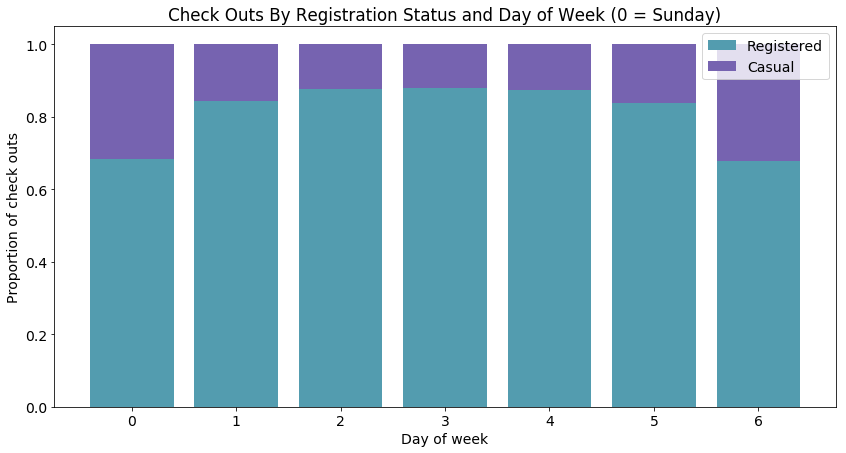

In [15]:
# 分天统计注册和偶然使用的情况
mean_by_reg_co_day = daily_data[['weekday', 'registered', 'casual']].groupby('weekday').mean()
# 分天统计注册和偶然使用的占比
mean_by_reg_co_day['total'] = mean_by_reg_co_day['registered'] + mean_by_reg_co_day['casual']
mean_by_reg_co_day['reg_prop'] = mean_by_reg_co_day['registered'] / mean_by_reg_co_day['total']
mean_by_reg_co_day['casual_prop'] = mean_by_reg_co_day['casual'] / mean_by_reg_co_day['total']


# 绘制堆积柱状图
def stackedbarplot(x_data, y_data_list, y_data_names, colors, x_label, y_label, title):
    _, ax = plt.subplots()
    # 循环绘制堆积柱状图
    for i in range(0, len(y_data_list)):
        if i == 0:
            ax.bar(x_data, y_data_list[i], color = colors[i], align = 'center', label = y_data_names[i])
        else:
            # 采用堆积的方式，除了第一个分类，后面的分类都从前一个分类的柱状图接着画
            # 用归一化保证最终累积结果为1
            ax.bar(x_data, y_data_list[i], color = colors[i], bottom = y_data_list[i - 1], align = 'center', label = y_data_names[i])
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'upper right') # 设定图例位置

# 调用绘图函数
stackedbarplot(x_data = mean_by_reg_co_day.index.values
               , y_data_list = [mean_by_reg_co_day['reg_prop'], mean_by_reg_co_day['casual_prop']]
               , y_data_names = ['Registered', 'Casual']
               , colors = ['#539caf', '#7663b0']
               , x_label = 'Day of week'
               , y_label = 'Proportion of check outs'
               , title = 'Check Outs By Registration Status and Day of Week (0 = Sunday)')

* 从这幅图你看出了什么？工作日 VS 节假日
* 为什么会有这样的差别？

#### 分组柱状图
* 多级类间绝对数值比较

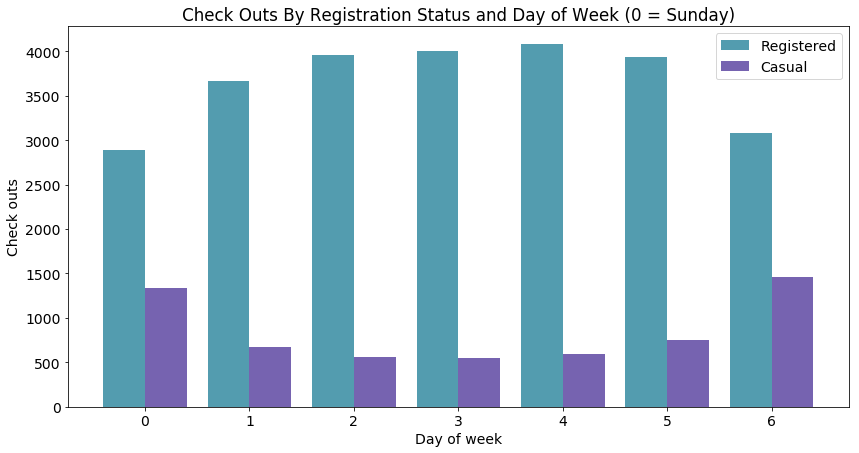

In [16]:
# 绘制分组柱状图的函数
def groupedbarplot(x_data, y_data_list, y_data_names, colors, x_label, y_label, title):
    _, ax = plt.subplots()
    # 设置每一组柱状图的宽度
    total_width = 0.8
    # 设置每一个柱状图的宽度
    ind_width = total_width / len(y_data_list)
    # 计算每一个柱状图的中心偏移
    alteration = np.arange(-total_width/2+ind_width/2, total_width/2+ind_width/2, ind_width)

    # 分别绘制每一个柱状图
    for i in range(0, len(y_data_list)):
        # 横向散开绘制
        ax.bar(x_data + alteration[i], y_data_list[i], color = colors[i], label = y_data_names[i], width = ind_width)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'upper right')

# 调用绘图函数
groupedbarplot(x_data = mean_by_reg_co_day.index.values
               , y_data_list = [mean_by_reg_co_day['registered'], mean_by_reg_co_day['casual']]
               , y_data_names = ['Registered', 'Casual']
               , colors = ['#539caf', '#7663b0']
               , x_label = 'Day of week'
               , y_label = 'Check outs'
               , title = 'Check Outs By Registration Status and Day of Week (0 = Sunday)')

* 偏移前：ind_width/2
* 偏移后：total_width/2
* 偏移量：total_width/2-ind_width/2

#### 箱式图
* 多级类间数据分布比较
* 柱状图 + 堆叠灰度图

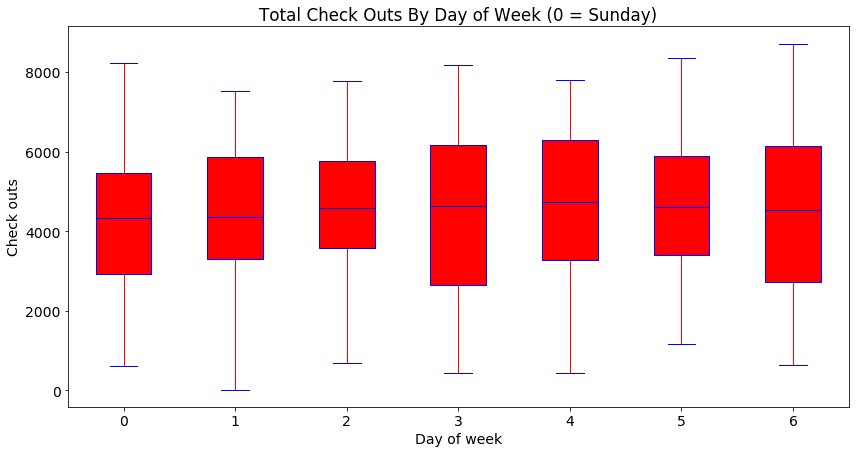

In [17]:
# 只需要指定分类的依据，就能自动绘制箱式图
days = np.unique(daily_data['weekday'])
bp_data = []
for day in days:
    bp_data.append(daily_data[daily_data['weekday'] == day]['cnt'].values)

# 定义绘图函数
def boxplot(x_data, y_data, base_color, median_color, x_label, y_label, title):
    _, ax = plt.subplots()

    # 设置样式
    ax.boxplot(y_data
               # 箱子是否颜色填充
               , patch_artist = True
               # 中位数线颜色
               , medianprops = {'color': base_color}
               # 箱子颜色设置，color：边框颜色，facecolor：填充颜色
               , boxprops = {'color': base_color, 'facecolor': median_color}
               # 猫须颜色whisker
               , whiskerprops = {'color': median_color}
               # 猫须界限颜色whisker cap
               , capprops = {'color': base_color})

    # 箱图与x_data保持一致
    ax.set_xticklabels(x_data)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

# 调用绘图函数
boxplot(x_data = days
        , y_data = bp_data
        , base_color = 'b'
        , median_color = 'r'
        , x_label = 'Day of week'
        , y_label = 'Check outs'
        , title = 'Total Check Outs By Day of Week (0 = Sunday)')

In [18]:
bp_data
days

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

## 简单总结
* 关联分析、数值比较：散点图、曲线图
* 分布分析：灰度图、密度图
* 涉及分类的分析：柱状图、箱式图